<a href="https://colab.research.google.com/github/Jundo22l/CAU_internship/blob/main/U_Net_with_VOC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision tqdm matplotlib

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_c, out_c):
            return nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.down1 = conv_block(in_channels, 64)
        self.down2 = conv_block(64, 128)
        self.down3 = conv_block(128, 256)
        self.down4 = conv_block(256, 512)
        self.down5 = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up4 = up_conv(1024, 512)
        self.conv4 = conv_block(1024, 512)
        self.up3 = up_conv(512, 256)
        self.conv3 = conv_block(512, 256)
        self.up2 = up_conv(256, 128)
        self.conv2 = conv_block(256, 128)
        self.up1 = up_conv(128, 64)
        self.conv1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool(d1))
        d3 = self.down3(self.pool(d2))
        d4 = self.down4(self.pool(d3))
        d5 = self.down5(self.pool(d4))

        up4 = self.up4(d5)
        merge4 = torch.cat([up4, d4], dim=1)
        c4 = self.conv4(merge4)
        up3 = self.up3(c4)
        merge3 = torch.cat([up3, d3], dim=1)
        c3 = self.conv3(merge3)
        up2 = self.up2(c3)
        merge2 = torch.cat([up2, d2], dim=1)
        c2 = self.conv2(merge2)
        up1 = self.up1(c2)
        merge1 = torch.cat([up1, d1], dim=1)
        c1 = self.conv1(merge1)

        return self.final(c1)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation

# Hyperparameters
batch_size = 8
learning_rate = 1e-4
num_epochs = 20
image_size = (256, 256)  # 고정된 이미지 크기 설정

# Data Loading
transform = transforms.Compose([
    transforms.Resize(image_size),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize(image_size),  # 마스크 크기 조정
    transforms.ToTensor()
])

train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True,
                                transform=transform, target_transform=target_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True,
                               transform=transform, target_transform=target_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = UNet(in_channels=3, out_channels=21).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    for i, (images, masks) in enumerate(train_loader):
        images = images.cuda()
        masks = masks.squeeze(1).long().cuda()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for images, masks in test_loader:
            images = images.cuda()
            masks = masks.squeeze(1).long().cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += masks.nelement()
            correct += (predicted == masks).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

# Save the model checkpoint
torch.save(model.state_dict(), 'unet_voc2012.pth')


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Epoch [1/20], Step [10/183], Loss: 2.9256
Epoch [1/20], Step [20/183], Loss: 2.8843
Epoch [1/20], Step [30/183], Loss: 2.5244
Epoch [1/20], Step [40/183], Loss: 2.4526
Epoch [1/20], Step [50/183], Loss: 2.3721
Epoch [1/20], Step [60/183], Loss: 2.3230
Epoch [1/20], Step [70/183], Loss: 2.2428
Epoch [1/20], Step [80/183], Loss: 2.1941
Epoch [1/20], Step [90/183], Loss: 2.1724
Epoch [1/20], Step [100/183], Loss: 2.1249
Epoch [1/20], Step [110/183], Loss: 2.0688
Epoch [1/20], Step [120/183], Loss: 2.0459
Epoch [1/20], Step [130/183], Loss: 2.0016
Epoch [1/20], Step [140/183], Loss: 1.9598
Epoch [1/20], Step [150/183], Loss: 1.9383
Epoch [1/20], Step [160/183], Loss: 1.9056
Epoch [1/20], Step [170/183], Loss: 1.8575
Epoch [1/20], Step [180/

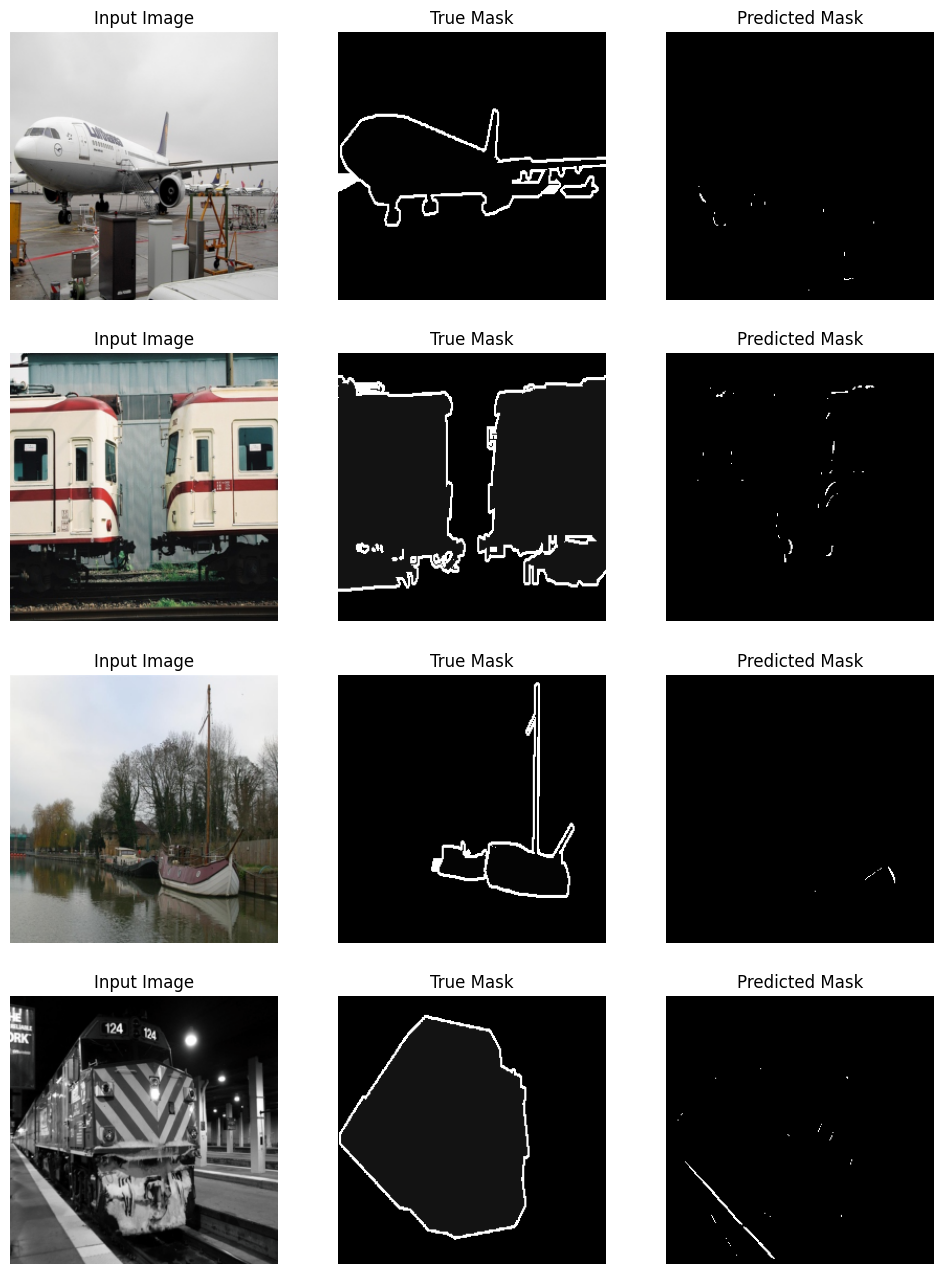

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

# Function to unnormalize the images
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Function to visualize predictions
def visualize_predictions(model, dataloader, num_images=4):
    model.eval()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
        for i in range(num_images):
            # Unnormalize the image for display
            img = images[i].cpu().clone()
            img = unnormalize(img, mean, std)
            img = F.to_pil_image(img)

            true_mask = masks[i].squeeze().cpu().numpy()
            pred_mask = predicted[i].cpu().numpy()

            axes[i, 0].imshow(img)
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(true_mask, cmap='gray')
            axes[i, 1].set_title("True Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

        plt.show()

# Use the function to visualize predictions on test set
visualize_predictions(model, test_loader, num_images=4)
